# The Leaky Integrate and Fire(LIF) Neuron Model

####  In this notebook, we will build up a leaky integrate-and-fire (LIF), exponential leaky integrate-and-fire (ELIF), adaptive exponential leaky integrate and fire (AELIF) neuron model and study their dynamics in response to various types of inputs. 

## Implementation from scratch

### Import Necessary Libraries

In [1]:
import numpy as np
import plotly.express as px
import math

## Leaky Integrate & Fire Model (LIF)
#### formulate
$\tau.\frac{du}{dt} = -(u - u_{rest}) + R.I(t)$, $\Delta u = u - u_{rest}$ ,$I_t = I(t)$

#### Threshhold
$ u(t) = \theta \implies \text{Fire + Reset } (u = u_{rest}) $

In [2]:
"""
Implementation of Leaky Integrate and Fire Neuron Model.
"""
class LIF:

    def __init__(self , parameters:dict):
        self.tau = parameters['tau']
        self.R = parameters['R']
        self.v_reset = parameters['v_reset']
        self.v_rest = parameters['v_rest']
        self.threshold = parameters['threshold']
        self.dt = parameters['dt']
        self.v = self.v_rest

        
    def getdv(self , I):
        return (-(self.v - self.v_rest) + self.R * I) \
                *self.dt / self.tau

    
    def get_minimum_I_to_spike(self):
        return (self.threshold - self.v_rest) / self.R
    

    def get_time_to_spike(self, I):
        return np.ceil(-1 * self.tau * np.log(1 - ((self.threshold - self.v_rest)/ (self.R * I))))
    
    def get_fire_rate(self, I):
        time_to_spike = self.get_time_to_spike(I)
        return 100 / time_to_spike
    
        
    def new_iteration(self, I):
        spike = 0
        self.v += self.getdv(I)
        if self.v >= self.threshold:
            self.v = self.v_reset
            spike = 1
        return spike
            
            
    
    def simulate(self , I_t , T):
        self.voltage = []
        self.spike_times = []
        for iteration in range(T):
            spike_flag = self.new_iteration(I_t[iteration])
            if spike_flag:
                self.spike_times.append(iteration)
            self.voltage.append(self.v)
        return self.voltage , self.spike_times

## Plotting Functions

In [3]:
def plot_neuron_info(v, I, s):
    x = range(len(v))
    v_fig = px.line(x=x, y=v, title="Voltage of neuron during the simulation")
    I_fig = px.line(x=x, y=I, title="Input that is given to the neuron")
    for spike_time in s:
        v_fig.add_vline(x=spike_time, line_width=2, line_dash="dash", line_color="red")
    v_fig.update_layout(xaxis_title='iteration', yaxis_title='voltage')
    I_fig.update_layout(xaxis_title='iteration', yaxis_title='I')
    v_fig.show()
    I_fig.show()

### Simulate LIF Model

In [4]:
def get_step_input_currents(I_values , I_period):
    I = []
    for value , time in zip(I_values , I_period):
        temp = [value for _ in range(time)]
        I += temp
    return I

### Set input and model parameters

In [5]:
I_values = [0 , 20 , 0]
I_periods = [5 , 30 , 10]
inputI = get_step_input_currents(I_values , I_periods)
config = {
    "v_reset" : -70,
    "v_rest": -70,
    "tau" : 10 ,
    "R" : 2 ,
    "threshold" : -50,
    "dt" : 1
}

In [6]:
neuron = LIF(config)
v , s = neuron.simulate(inputI , sum(I_periods))

In [7]:
plot_neuron_info(v , inputI, s)

## Exponential LIF Model
#### formulate
$\tau.\frac{du}{dt} = -(u - u_{rest}) + R.I(t) + \Delta_{T}exp(\frac{u - \theta_{rh}}{\Delta_{T}})$

First part describe the leak of a passive membrane same as LIF model.

$\Delta_{T}$ is the sharpness parameter.

$\theta_{rh}$ is the firing threshold.

In [8]:
class ELIF(LIF):

    def __init__(self , parameters:dict):
        super().__init__(parameters)
        self.deltaT = parameters['deltaT']

    def getdv(self , I):
        return ((-(self.v - self.v_rest) + self.R * I) + self.deltaT * math.exp((self.v - self.threshold)/self.deltaT)) * \
        (self.dt / self.tau)
            


In [9]:
I_values = [0 , 10]
I_periods = [5 , 50]
inputI = get_step_input_currents(I_values , I_periods)
config = {
    "v_reset" : -70,
    "v_rest": -70,
    "tau" : 10 ,
    "R" : 2 ,
    "deltaT": 2.,
    "threshold" : -50,
    "dt" : 1
}
neuron = ELIF(config)
v , s = neuron.simulate(inputI , sum(I_periods))
plot_neuron_info(v, inputI, s)

## Addaptive Exponential LIF Model
#### formulate
$\tau.\frac{du}{dt} = -(u - u_{rest}) + R.I(t) + \Delta_{T}exp(\frac{u - \theta_{rh}}{\Delta_{T}}) - Rw$

$\tau.\frac{dw}{dt} = a(u - u_{rest}) - w + b \tau_w \sum\limits_{t^f}\sigma(t - t^f)$

- At each threshold crossing, the adaptation variable w is increased by an amount b
- Adaptation is characterized by two parameters:
    - the parameter a is the source of subthreshold adaptation, because it couples adaptation to the voltage
    - spike-triggered adaptation is controlled by a combination of a and b.

In [27]:
class AELIF(LIF):
    
    def __init__(self , parameters):
        super().__init__(parameters)
        self.deltaT = parameters['deltaT']
        self.tau_m = parameters['tau_m']
        self.tau_w = parameters['tau_w']
        self.a = parameters['a']
        self.b = parameters['b']
        self.w = parameters['w']

    
    def getdv(self , I):
        return ((-(self.v - self.v_rest) + self.R * (I - self.w)) \
        + self.deltaT * math.exp((self.v - self.threshold)/self.deltaT)) * self.dt / self.tau_m
    
    
    def getdw(self , t):
        return self.a * (self.v - self.v_rest) - self.w + self.b * self.tau_w * self.spike_times.count(t)
    
    
    def new_iteration(self, I , iteration):
        spike = super().new_iteration(I)
        if spike:
            self.spike_times.append(iteration)
        self.w += self.getdw(iteration)
    
    def simulate(self , I_t , T):
        self.voltage = []
        self.spike_times = []
        for iteration in range(T):
            self.new_iteration(I_t[iteration], iteration)
            self.voltage.append(self.v)
        return self.voltage , self.spike_times
    

In [34]:
I_values = [30, 0]
I_periods = [1000, 200]
inputI = get_step_input_currents(I_values , I_periods)
config = {
    "v_reset" : -70,
    "v_rest": -70,
    "tau" : 10 ,
    "R" : 5. ,
    "deltaT": 1.,
    "threshold" : -50.,
    "dt" : 0.01,
    "tau_w": 10.,
    "tau_m": 5.,
    "a": 1.,
    "b": 1.5,
    "w": 2.

}
neuron = AELIF(config)
v , s = neuron.simulate(inputI , sum(I_periods))
plot_neuron_info(v, inputI, s)

### Put Them All Together!

In [12]:
def create_model(model_name, config):
    if model_name == "LIF":
        behaviourObj = LIF(config)
    elif model_name == "ELIF":
        behaviourObj = ELIF(config)
    elif model_name == "AELIF":
        behaviourObj = AELIF(config)
    else:
        raise Exception("Invalid model name")
    return behaviourObj

def createAndRunModel(model_name , config , duration , plot = False):
    model = create_model(model_name, config)
    v , s = model.simulate(config['I_t'] , duration)
    if plot:
        plot_neuron_info(v , config['I_t'], s)
    return v, s

## F-I Curve

In [13]:
def getFICurveData(config , minI , maxI):
    I_values = list(range(minI, maxI + 1))
    fire_rates = []
    model = create_model("LIF", config)
    for current_I in I_values:
        current_fire_rate = model.get_fire_rate(current_I)
        fire_rates.append(current_fire_rate)
    return I_values , fire_rates


def getFICurveDataIterative(model_name, config, minI, maxI):
    duration = 100
    I_values = list(range(minI, maxI + 1))
    fire_rates = []
    for current_I in I_values:
        config["I_t"] = get_step_input_currents([current_I], [duration])
        v, s = createAndRunModel(model_name, config, duration)
        fire_rates.append(len(s)/duration)
    return I_values , fire_rates


def plotFICurve(model_name , config , minI , maxI):
    if model_name == "LIF":
        I , f = getFICurveData(config , minI , maxI)
    else:
        I, f = getFICurveDataIterative(model_name, config, minI, maxI)
    fig = px.line(x=I, y=f, title="F-I Curve")
    fig.update_layout(xaxis_title='I', yaxis_title='Fire Rate')
    fig.show()
        

In [14]:
plotFICurve("LIF", config , 1 , 40)

/var/folders/1d/nqf6rgrn6_vb61brn3hyc4t40000gn/T/ipykernel_9473/3340036918.py:26: RuntimeWarning:

invalid value encountered in log



## Gaussian white noise

In [15]:
def generateNormalI(mean , std , size):
    return np.random.normal(mean , std , size)

In [16]:
params = {
        "v_reset" : -65,
        "v_rest": -70,
        "tau" : 10 ,
        "R" : 5 ,
        "I_t": generateNormalI(8 , 1 , 100),
        "threshold" : -40,
        "dt" : 1
    }
v, s = createAndRunModel("LIF" , params , 100 , plot=True)

## coefficient of variation (CV) of the interspike interval (ISI)

In [17]:
def get_ISI(model_name , params , duration):
    v , spike_times = createAndRunModel(model_name , params , duration)
    return np.diff(spike_times)

def CV_ISI(model_name , params , duration):
    isi_values = get_ISI(model_name , params , duration)
    return np.std(isi_values) / np.mean(isi_values)

In [41]:
params = {
        "v_reset" : -65,
        "v_rest": -70,
        "tau" : 10 ,
        "R" : 5 ,
        "threshold" : -40,
        "dt" : 1
    }
I = generateNormalI(10 , 3 , 200)
params["I_t"] = I
cv_isi = CV_ISI("LIF", params, 200)
isi = get_ISI("LIF", params, 200)
print(f"cv_isi:{cv_isi}")
fig = px.histogram(isi, range_x=(2,10), title="Histogram of ISI")
fig.update_layout(xaxis_title="ISI")
fig.show()

cv_isi:0.17925669858869894


In [44]:
params = {
    "v_reset" : -70,
    "v_rest": -70,
    "tau" : 10 ,
    "R" : 5. ,
    "deltaT": 1.,
    "threshold" : -50.,
    "dt" : 0.01,
    "tau_w": 10.,
    "tau_m": 5.,
    "a": 1.,
    "b": 1.5,
    "w": 2.

}
I_mean = np.arange(2,50,3)
I_std = np.arange(0,30,1.5)
spk_count = np.zeros((len(I_mean),len(I_std)))
cv_isi = np.empty((len(I_mean),len(I_std)))
cv_isi[:] = np.NaN
duration = 400

for i in range(len(I_mean)):
    for j in range(len(I_std)):
        I_normal = generateNormalI(I_mean[i] , I_std[j] ,duration) 
        params["I_t"] = I_normal
        v, spike_times = createAndRunModel("AELIF" , params , duration)
        if not spike_times:
            continue
        spk_count[i,j] = len(spike_times)
        if spk_count[i,j]>3:
            isi = np.diff(np.array(spike_times))
            cv_isi[i,j] = np.std(isi)/np.mean(isi)

/var/folders/1d/nqf6rgrn6_vb61brn3hyc4t40000gn/T/ipykernel_9473/2833097196.py:2: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


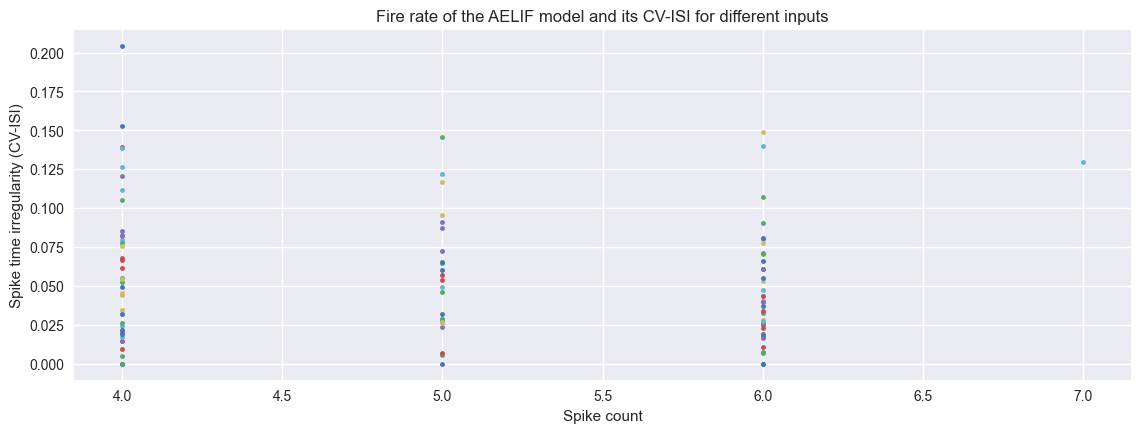

In [46]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.figure(figsize=(30,10))
plt.subplot(2,2,2)
plt.plot(spk_count,cv_isi,'.')
plt.xlabel('Spike count')
plt.ylabel('Spike time irregularity (CV-ISI)')
plt.title("Fire rate of the AELIF model and its CV-ISI for different inputs")
plt.legend()